In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = '/home/christos/Desktop/unet/data/train/'
#TEST_PATH = '/home/christos/Desktop/unet/input/stage1_test'
#FINAL_TEST_PATH = '../input/stage2_test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids = next(os.walk(TEST_PATH))[1]
#final_test_ids = next(os.walk(FINAL_TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)
Y_fgbg_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
Y_edge_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.tif')
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n,:,:,0] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    edge = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/fgbg/'))[2]:
        #Read individual masks
        mask_ = imread(dir_path + path + '/fgbg/' + mask_file)
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)
    #Append mask to numpy array for train dataset
    Y_fgbg_train[n] = mask
    
    for edge_file in next(os.walk(path + '/edge/'))[2]:
        #Read individual masks
        mask_ = imread(dir_path + path + '/edge/' + edge_file)
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        #Overlay individual masks to create a final mask for corresponding image
        edge = np.maximum(edge, mask_)   
    #Append mask to numpy array for train dataset
    Y_edge_train[n] = edge
'''
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img
'''
print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 1000/1000 [00:11<00:00, 89.46it/s]

Done!


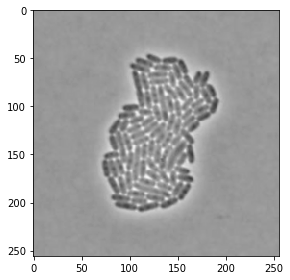

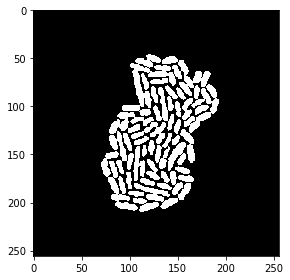

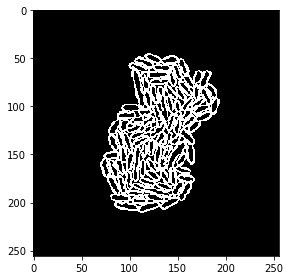

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix,:,:,0])
plt.show()
imshow(np.squeeze(Y_fgbg_train[ix]))
plt.show()
imshow(np.squeeze(Y_edge_train[ix]))
plt.show()

In [5]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [6]:
model_fgbg = Model(inputs=[inputs], outputs=[outputs])
model_fgbg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model_fgbg.summary()

model_edge = Model(inputs=[inputs], outputs=[outputs])
model_edge.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model_edge.summary()

In [7]:
# Fit model for forground-background
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('/home/christos/Desktop/unet/trained_models/model_fgbg_unet_checkpoint_v3.h5', verbose=1, save_best_only=True)
results_fgbg = model_fgbg.fit(X_train, Y_fgbg_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 900 samples, validate on 100 samples
Epoch 1/10
 64/900 [=>............................] - ETA: 9:16 - loss: 0.6851 - accuracy: 0.6453WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [8]:
# Fit model for the edges of the bacteria
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('/home/christos/Desktop/unet/trained_models/model_edge_unet_checkpoint.h5', verbose=1, save_best_only=True)
results_edge = model_edge.fit(X_train, Y_edge_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 900 samples, validate on 100 samples
Epoch 1/10
896/900 [============================>.] - ETA: 0s - loss: 0.5214 - accuracy: 0.8315
Epoch 00001: val_loss improved from inf to 0.29314, saving model to /home/christos/Desktop/unet/trained_models/model_edge_unet_checkpoint.h5
900/900 [==============================] - 25s 27ms/sample - loss: 0.5202 - accuracy: 0.8319 - val_loss: 0.2931 - val_accuracy: 0.8515
Epoch 2/10
896/900 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9115
Epoch 00002: val_loss improved from 0.29314 to 0.21305, saving model to /home/christos/Desktop/unet/trained_models/model_edge_unet_checkpoint.h5
900/900 [==============================] - 23s 26ms/sample - loss: 0.2135 - accuracy: 0.9116 - val_loss: 0.2130 - val_accuracy: 0.9126
Epoch 3/10
896/900 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9189
Epoch 00003: val_loss improved from 0.21305 to 0.19696, saving model to /home/christos/Desktop/unet/trained_mo

In [8]:
# Predict on train, val and test fgbg
model_fgbg = load_model('/home/christos/Desktop/unet/trained_models/model_fgbg_unet_checkpoint.h5')
preds_fgbg_train = model_fgbg.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_fgbg_val = model_fgbg.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_fgbg_train_t = (preds_fgbg_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Predict on train, val and test edge
model_edge = load_model('/home/christos/Desktop/unet/trained_models/model_edge_unet_checkpoint.h5')
preds_edge_train = model_edge.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_edge_val = model_edge.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_edge_train_t = (preds_edge_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)



# Create list of upsampled test masks
#preds_test_upsampled = []
#for i in range(len(preds_test_t)):
   # preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]), 
      #                                 (sizes_test[i][0], sizes_test[i][1]), 
       #                                mode='constant', preserve_range=True))

100/100 [==============================] - 8s 79ms/sample


172


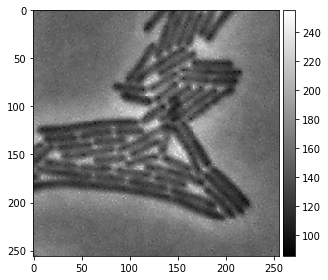

255.0


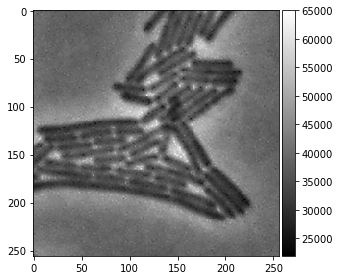

1/1 [==============================] - 0s 9ms/sample


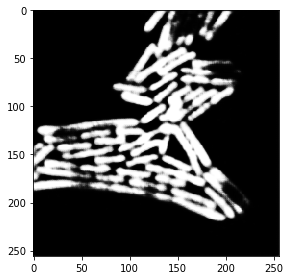

1/1 [==============================] - 0s 9ms/sample


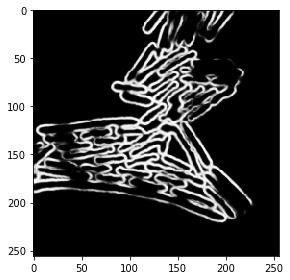

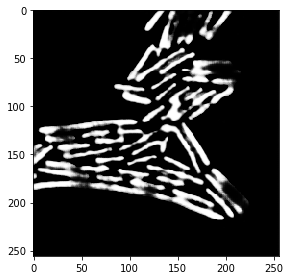

In [40]:
from skimage.color import rgb2gray
original=imread('/home/christos/Desktop/ScottA_test.tif')
print(original.max())
original=original.astype('float32')
original *= 255.0/original.max()
imshow(original,cmap='gray')
plt.show()
print(original.max())

grayscale = rgb2gray(original)*255
imshow(grayscale,cmap="gray")
plt.show()

pred_fgbg=model_fgbg.predict(np.reshape(original,(1,256,256,1)), verbose=1)
imshow(pred_fgbg[0,:,:,0])
plt.show()

pred_edge=model_edge.predict(np.reshape(original,(1,256,256,1)), verbose=1)
imshow(pred_edge[0,:,:,0])
plt.show()

imshow(np.clip((pred_fgbg[0,:,:,0]-pred_edge[0,:,:,0]),0,1))
plt.show()

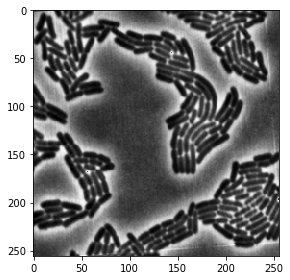

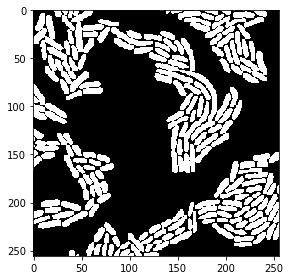

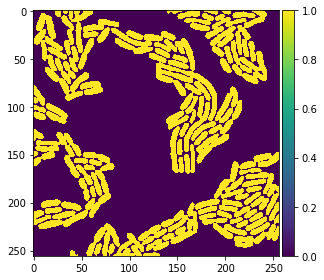

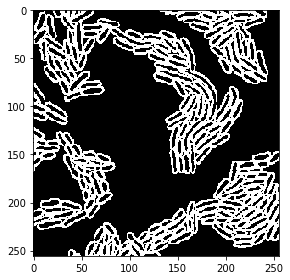

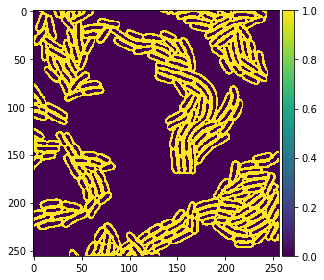

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(train_ids))
imshow(X_train[ix,:,:,0])
plt.show()
imshow(np.squeeze(Y_fgbg_train[ix]))
plt.show()
imshow(np.squeeze(preds_fgbg_train_t[ix]))
plt.show()
imshow(np.squeeze(Y_edge_train[ix]))
plt.show()
imshow(np.squeeze(preds_edge_train_t[ix]))
plt.show()

